In [2]:
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import matplotlib
import numpy as np 
import pandas as pd

from utils import *

def plot_intervals(intervals, ax, alpha=0.25, color='red'):
    for interval in intervals:
        ax.axvspan(*interval, alpha=alpha, color=color, linewidth=0)
        
def init_axis(ax, start_time, finish_time):
    ax.set_xlim(start_time, finish_time)
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

def plot_legend(alpha=0.25, loc=(0.3,0.2)):
    for k,v in ALL_WINDOW_PROPERTIES.items():
        plt.gca().scatter([],[], label=k, color=v['color'], alpha=alpha) # for legend purposes
    plt.legend(loc=loc,ncols=len(ALL_WINDOW_PROPERTIES))


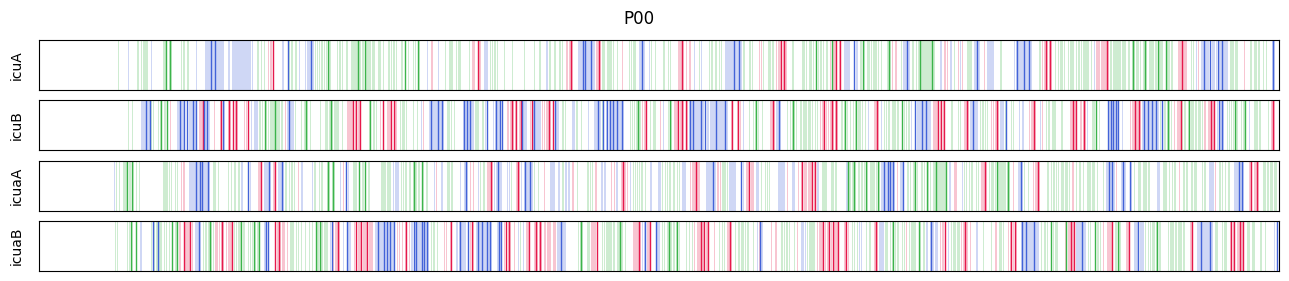

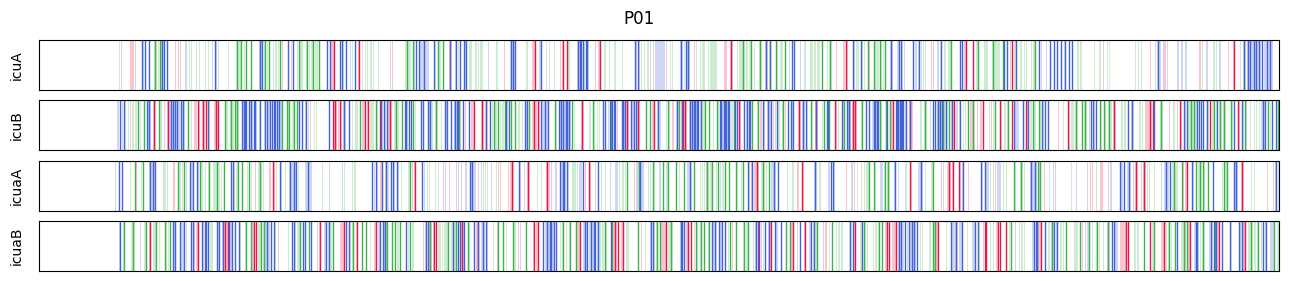

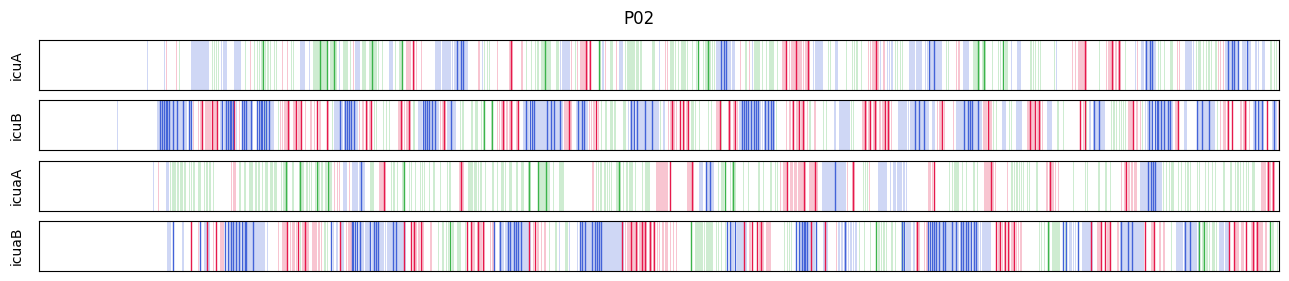

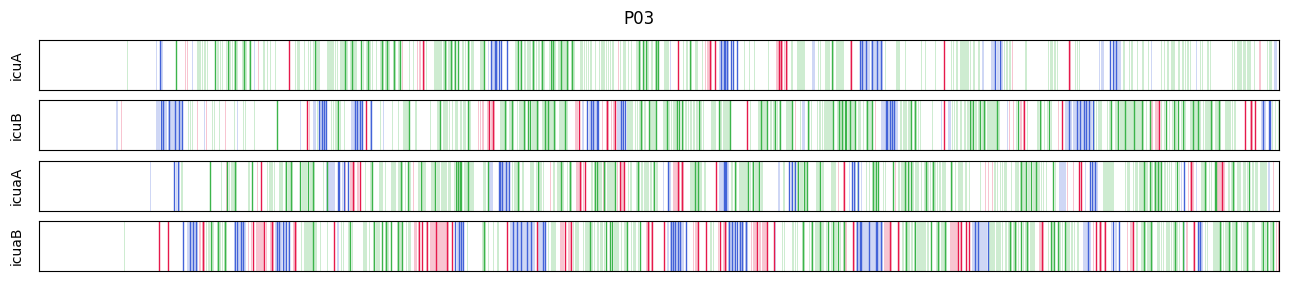

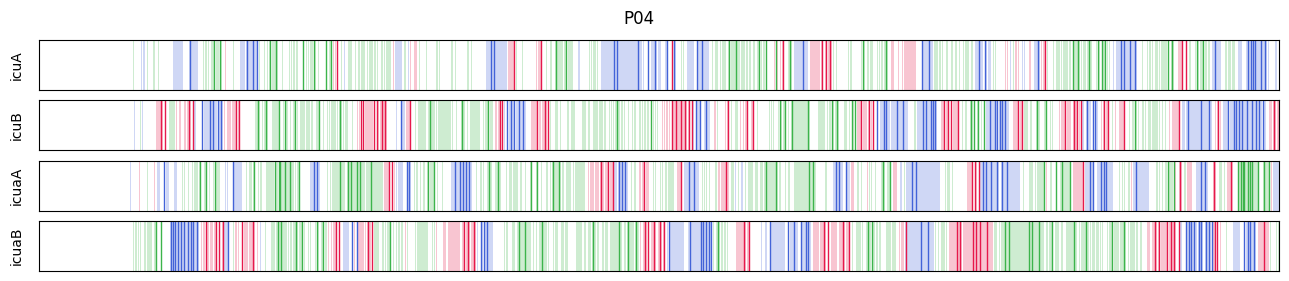

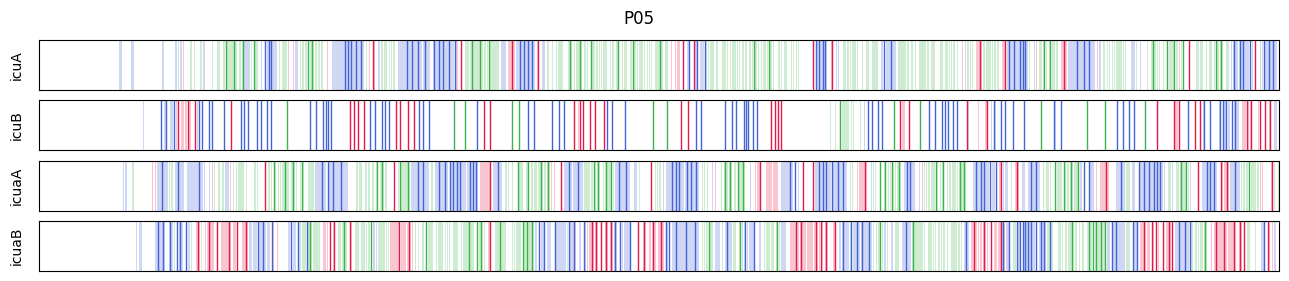

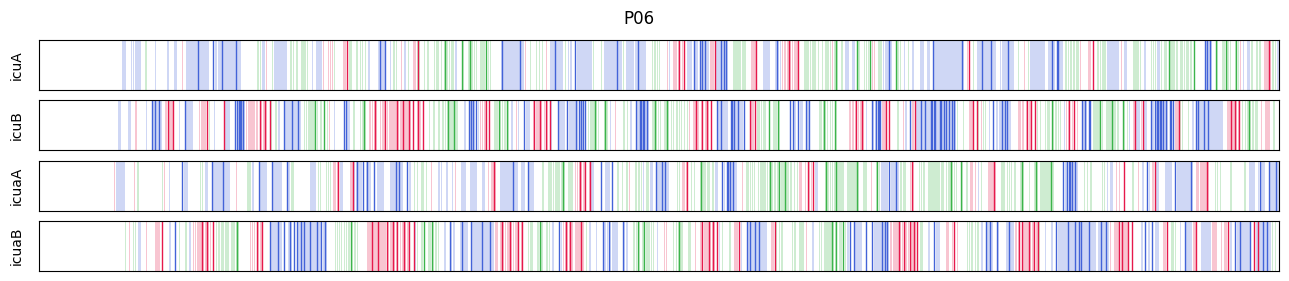

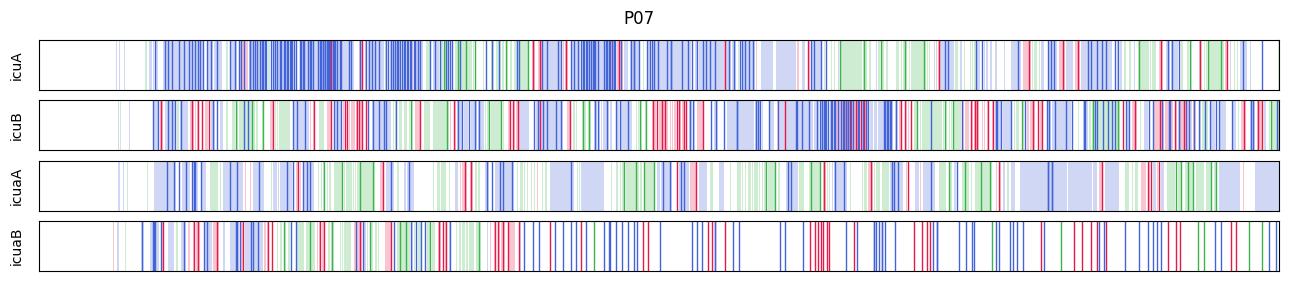

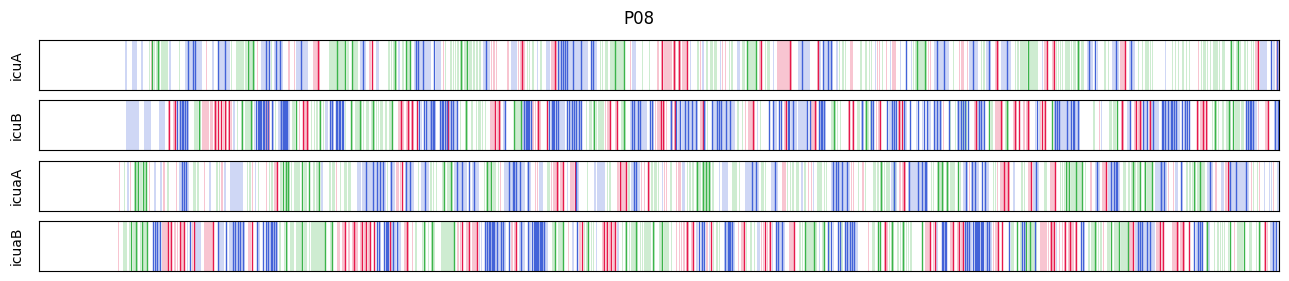

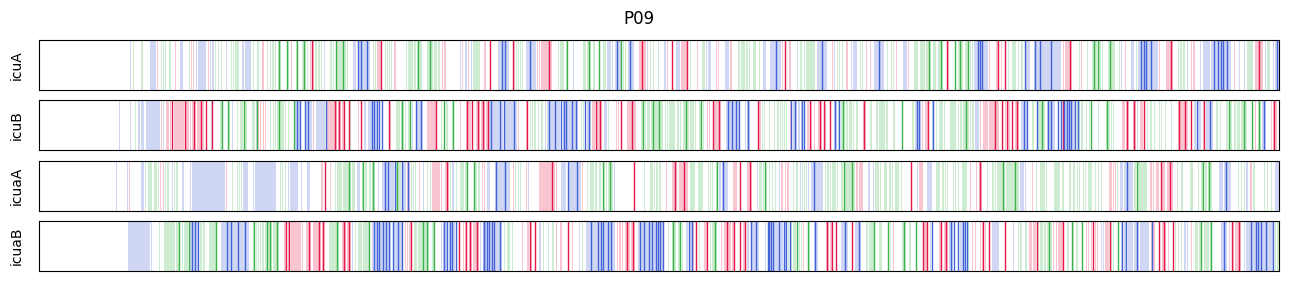

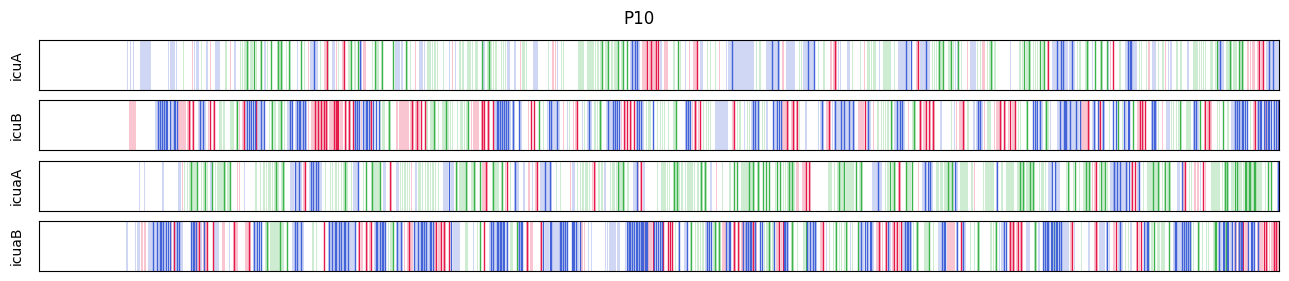

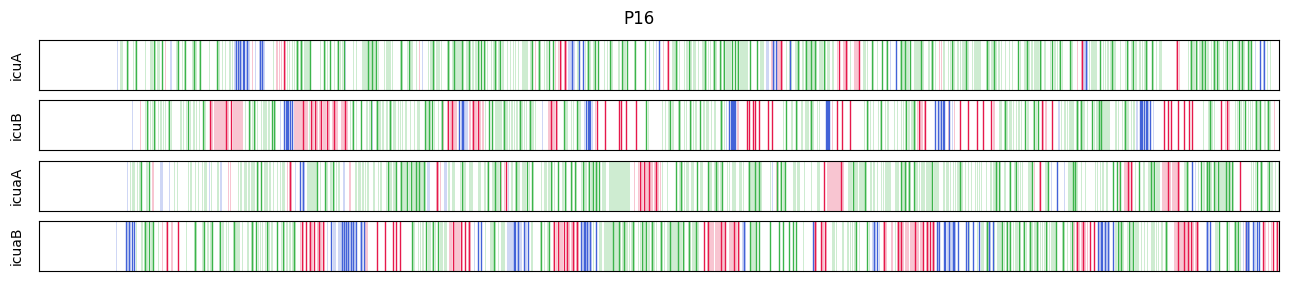

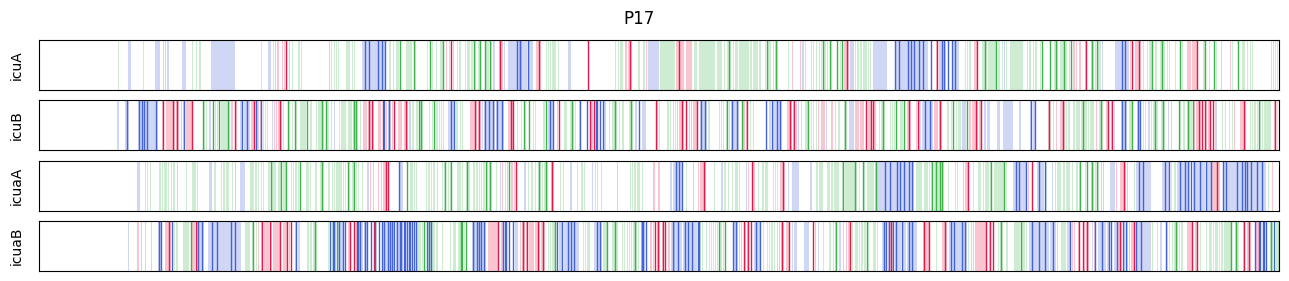

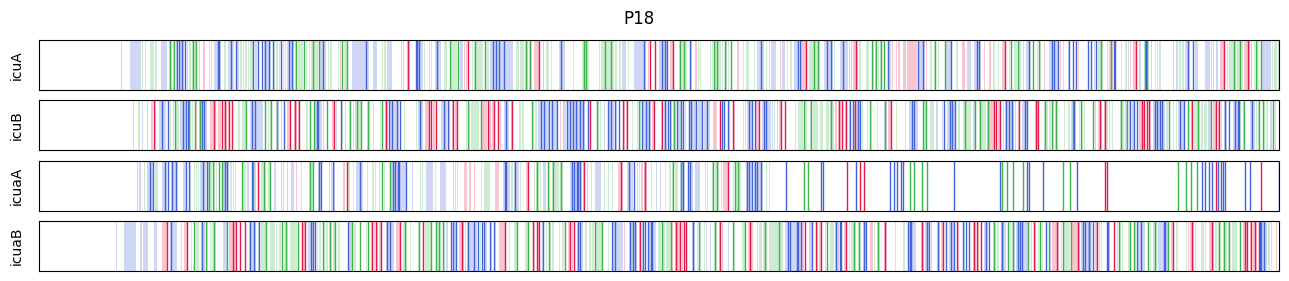

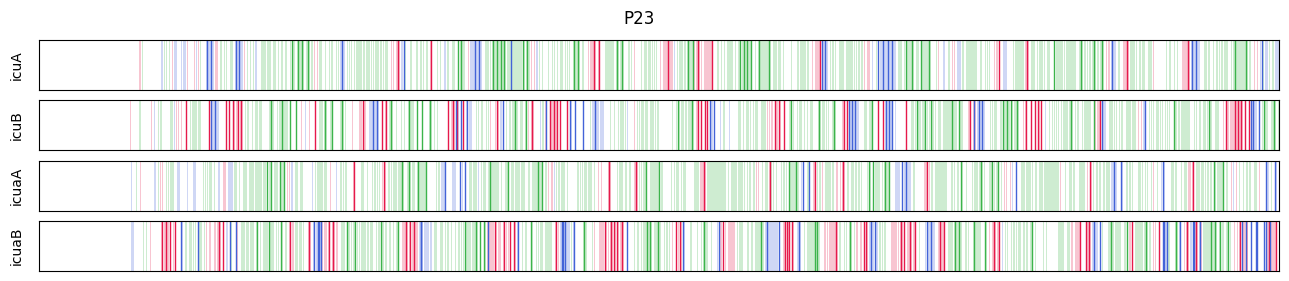

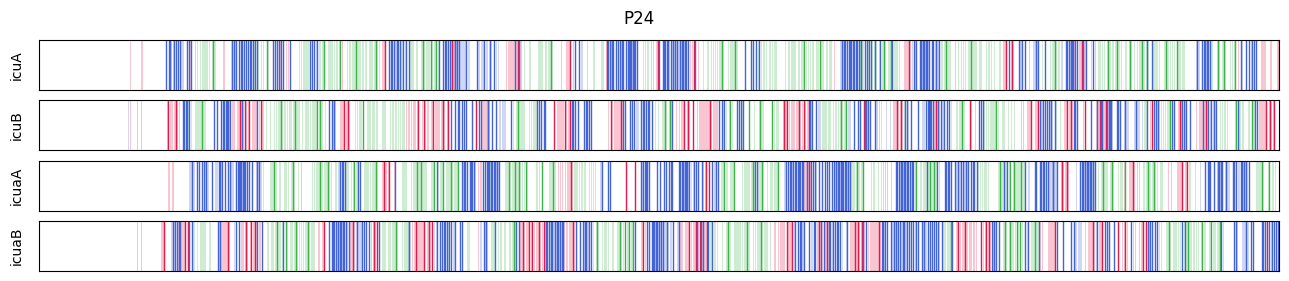

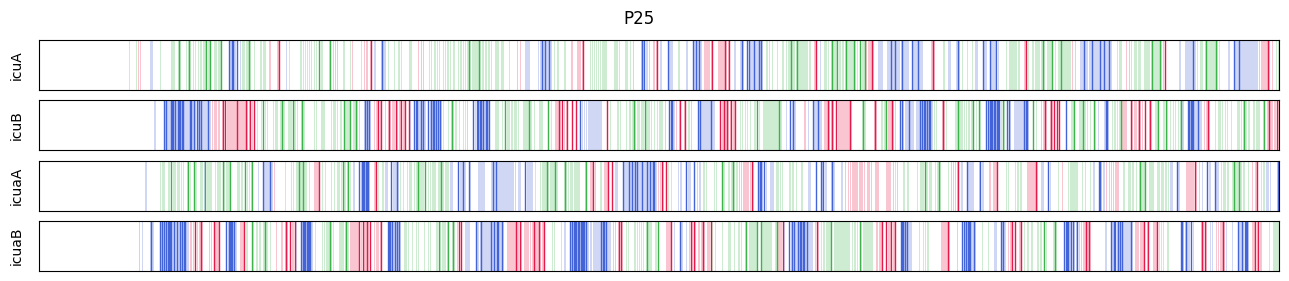

In [2]:
# PLOT GAZE INTERVALS

data = load_nested_dict('data/Processed') 
for participant, _data1 in data.items(): #itertools.islice(data.items(), 1):
    fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16,3))
    fig.suptitle(participant)
    #plt.subplots_adjust(wspace=0.1, hspace=0.2)
    for ax, (experiment, _data2) in zip(axes, _data1.items()):
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        init_axis(ax, start_time, finish_time)
        ax.set_ylabel(experiment[3:])
        eye_data = _data2['eye_tracking']
        gaze = eye_data['gaze'].to_numpy()
        for task, window_properties in ALL_WINDOW_PROPERTIES.items():
            intaskbox = in_box(eye_data['x'].to_numpy(), eye_data['y'].to_numpy(), window_properties['position'], window_properties['size'])
            gazeintaskbox = np.logical_and(intaskbox, gaze)
            # pad with next, the person is not gazing the whole time if the eyetracker crashes/never produces another event.
            result = compute_time_intervals(gazeintaskbox, eye_data['timestamp'].to_numpy(), start_time, finish_time, pad='next')
            plot_intervals(result.intervals, ax, color=window_properties['color'])
        # plot clicks
        mouse_data = _data2['mouse']
        for task, data in mouse_data.groupby(mouse_data['task']):
            for x in data['timestamp']:
                ax.axvline(x, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1, fillstyle='none')
        # plot keyboard
        kdata = _data2['keyboard']
        for x in kdata['timestamp'][kdata['action'] == 'press']:
            ax.axvline(x, color=ALL_WINDOW_PROPERTIES['tracking']['color'], linewidth=1, fillstyle='none')

        

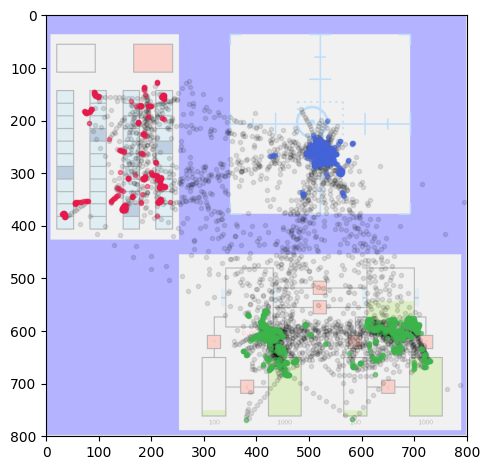

In [3]:

def plot_eyetracking(data, participant, experiment, show_out_of_bounds=False):
    eye_data = data[participant][participant + experiment]['eye_tracking']
    import matplotlib.image as mpimg
    img = mpimg.imread('./results/images/background.png') # background image
    WINDOW_SIZE = (800,800)
    fig = plt.figure()
    plt.imshow(img, alpha=0.3)
    t, x, y, gaze = eye_data['timestamp'].astype(np.float32), eye_data['x'].astype(np.float32), eye_data['y'].astype(np.float32), eye_data['gaze'].to_numpy()
    x_gaze, y_gaze = x[gaze], y[gaze]
    plt.scatter(x[np.logical_not(gaze)], y[np.logical_not(gaze)], alpha=0.1, marker=".", color="black")
    for _, properties in ALL_WINDOW_PROPERTIES.items():
        in_task = in_box(x_gaze, y_gaze, properties['position'], properties['size']).to_numpy()
        plt.scatter(x_gaze[in_task], y_gaze[in_task], color=properties['color'], marker=".", alpha=0.5)
        #rect = plt.Rectangle(properties['position'], *properties['size'], color="red",  linewidth=2, fill=False)
        #plt.gca().add_patch(rect)
    if not show_out_of_bounds:
        plt.gca().set_xlim(0,WINDOW_SIZE[0])
        plt.gca().set_ylim(0,WINDOW_SIZE[1])
        plt.gca().invert_yaxis()
        
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    return fig

data = load_nested_dict('data/Processed') 
fig = plot_eyetracking(data, "P18", "icuaA", show_out_of_bounds=False)

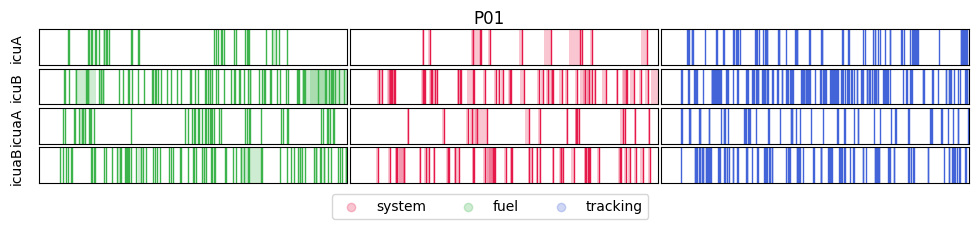

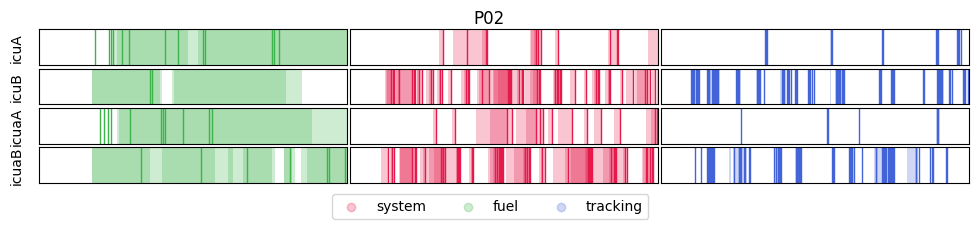

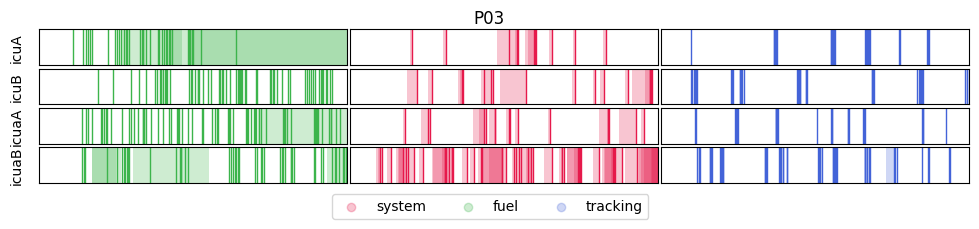

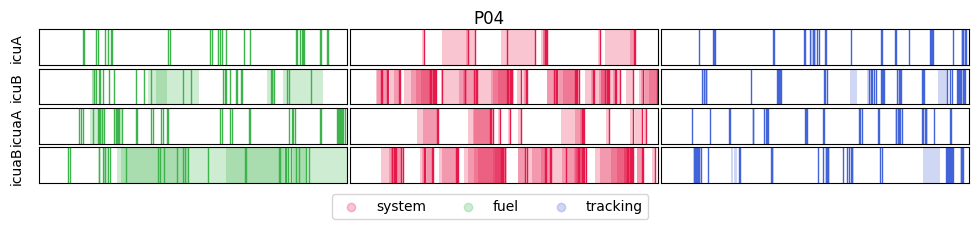

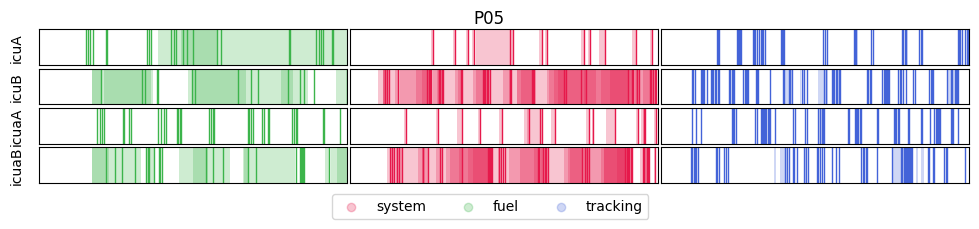

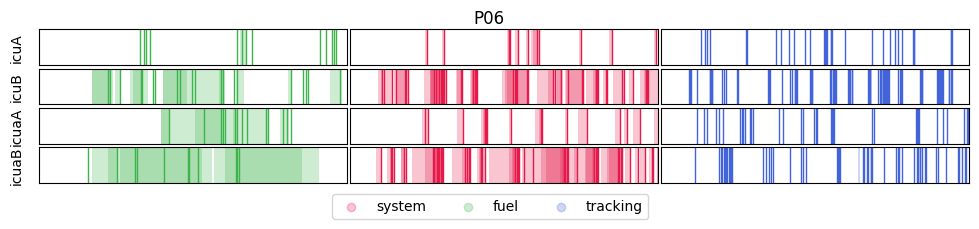

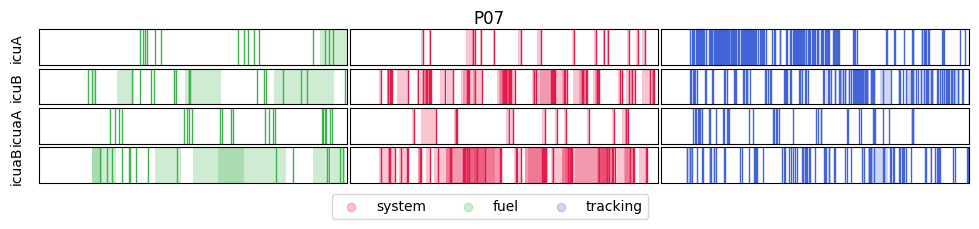

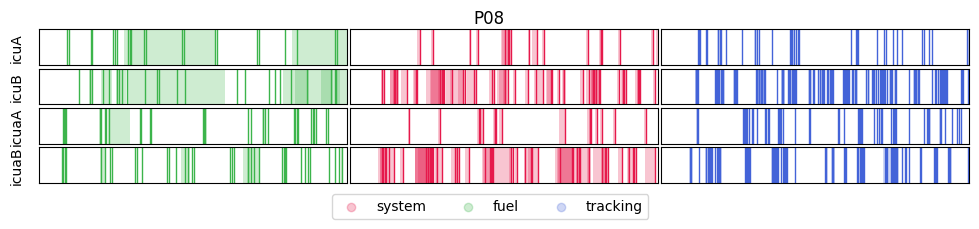

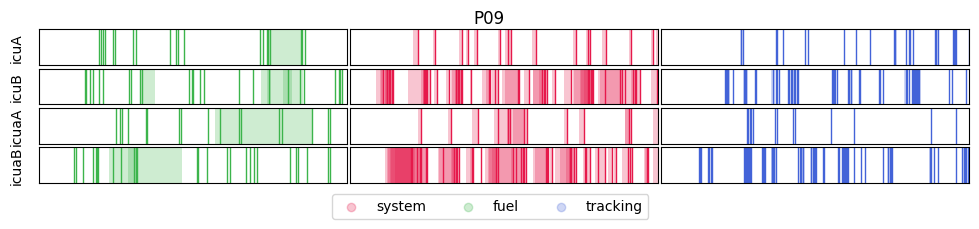

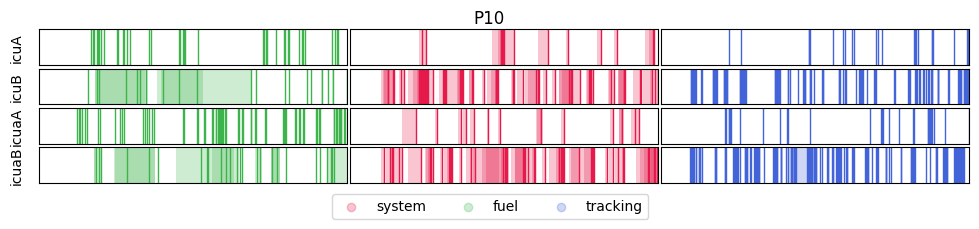

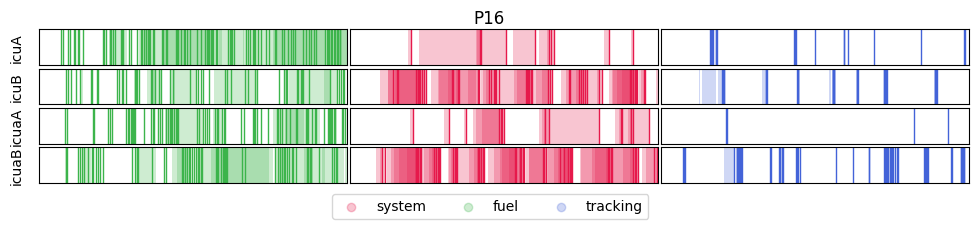

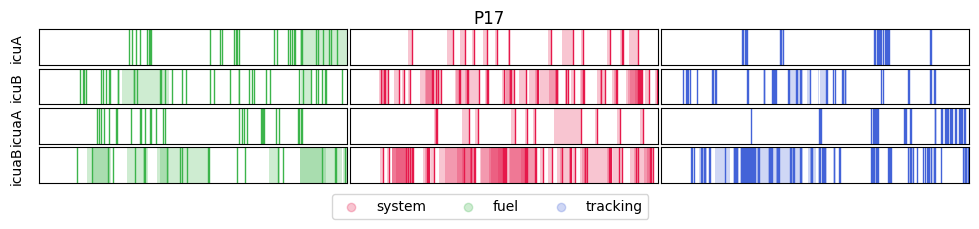

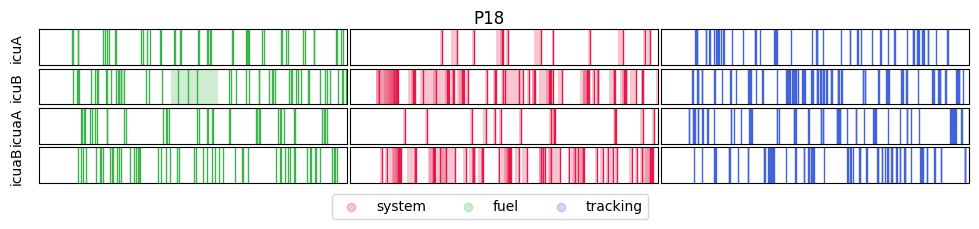

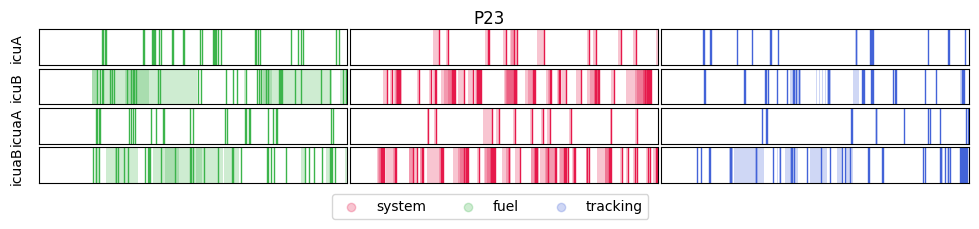

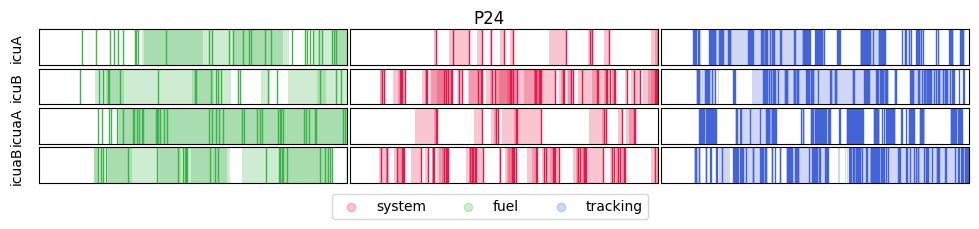

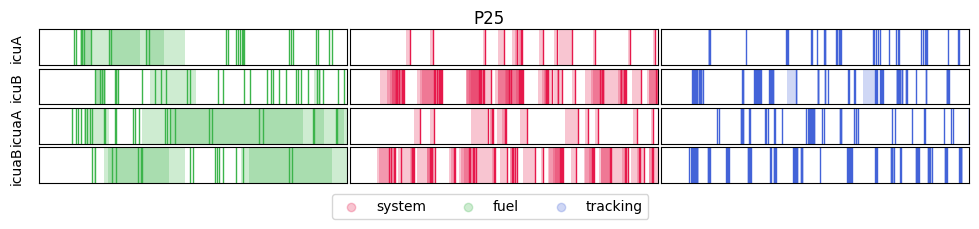

In [3]:
# FAILURE BARS FOR INDIVIDUALS ON EACH TASK 
data = load_nested_dict('data/Processed') 
for participant, _data1 in data.items():
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12,2))
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    for _axes, (experiment, _data2) in zip(axes, _data1.items()):
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        _axes[0].set_ylabel(experiment[3:], rotation=90)
        
        _axes = {task:ax for ax,task in zip(_axes, sorted(ALL_WINDOW_PROPERTIES.keys()))}
        # plot failure intervals
        for task, _data3 in sorted(_data2['tasks'].items()):
            ax = _axes[task]
            init_axis(ax, start_time, finish_time)
            intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
            for interval in intervals:
                plot_intervals(interval, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])
        
        # plot clicks
        mouse_data = _data2['mouse']
        for task, data in mouse_data.groupby(mouse_data['task']):
            for x in data['timestamp']:
                _axes[task].axvline(x, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1)
        
        # plot keyboard
        kdata = _data2['keyboard']
        for x in kdata['timestamp'][kdata['action'] == 'press']:
            _axes['tracking'].axvline(x, color=ALL_WINDOW_PROPERTIES['tracking']['color'], linewidth=1)
        
    plot_legend(loc=(-1.07, -1))
    fig.suptitle(participant)

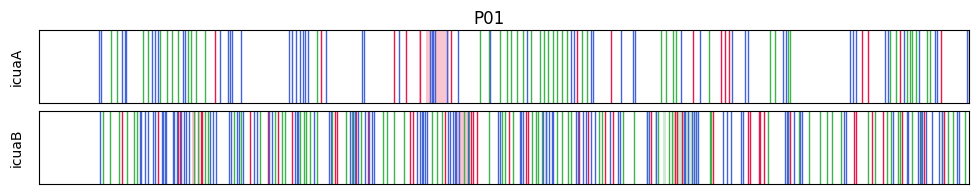

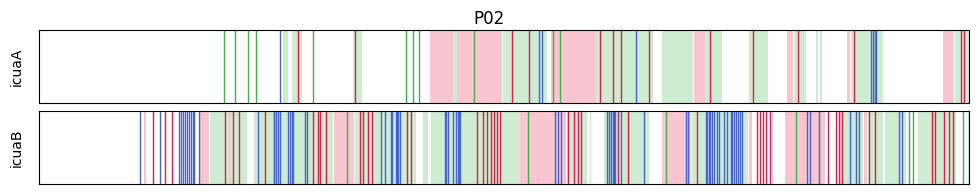

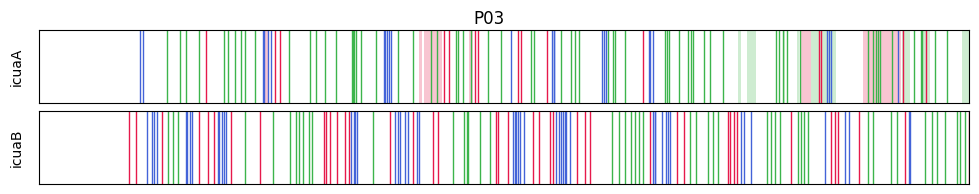

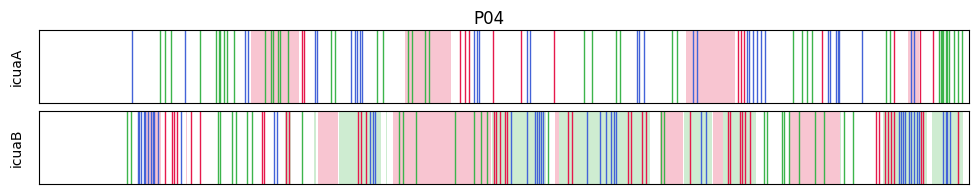

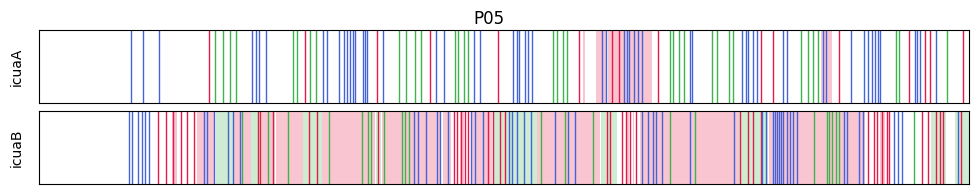

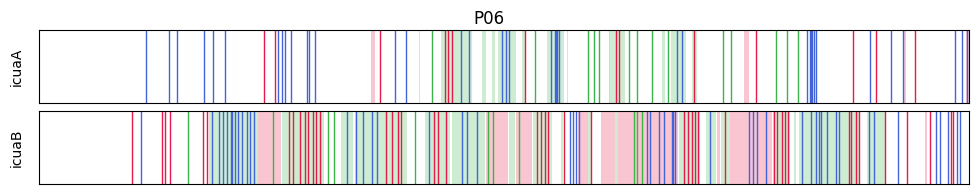

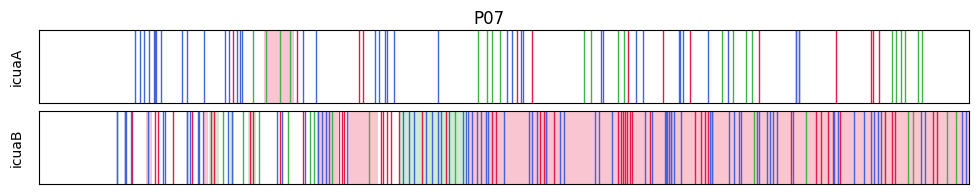

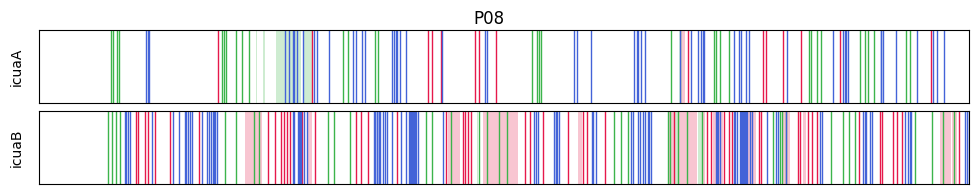

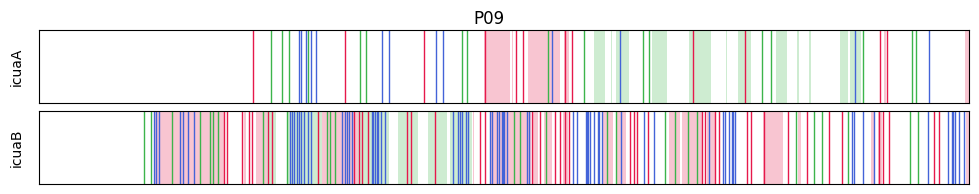

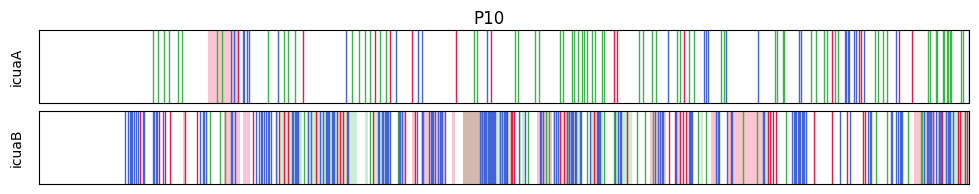

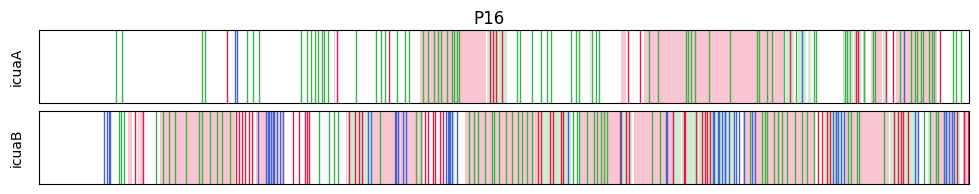

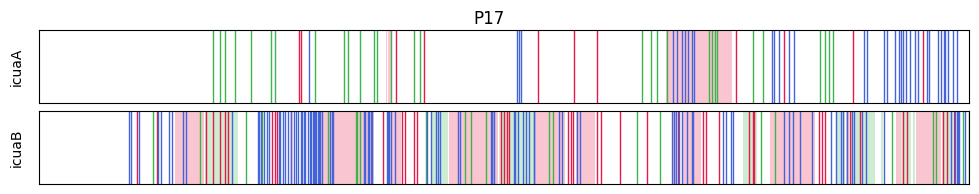

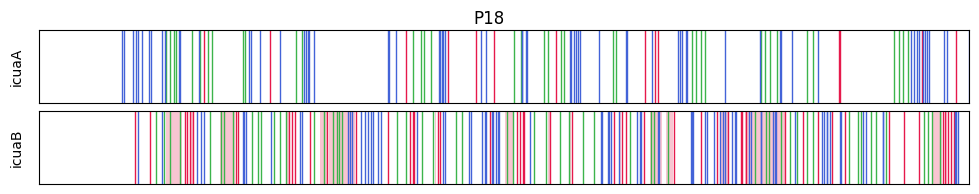

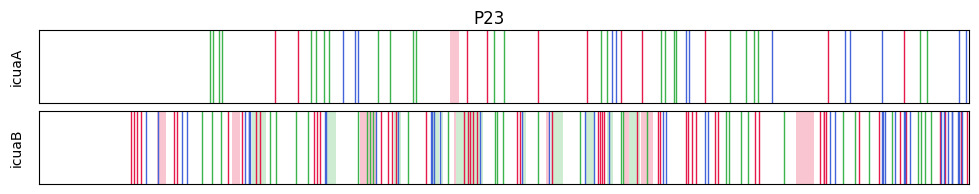

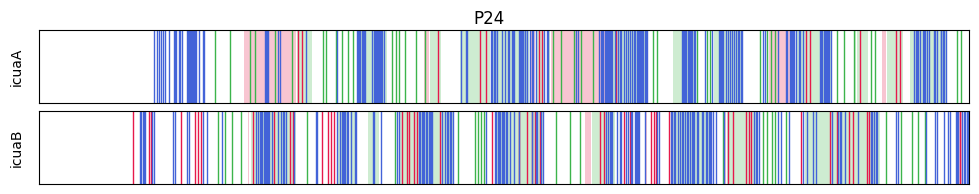

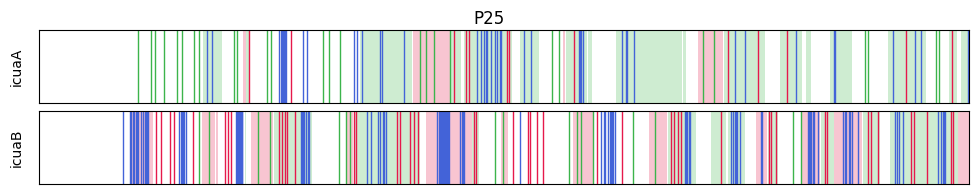

In [4]:
# AGENT FEEDBACK BARS FOR INDIVIDUALS ON EACH TASK 

data = load_nested_dict('data/Processed') 
for participant, _data1 in data.items():
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,2))
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    for ax, (experiment, _data2) in zip(axes, [(k,v) for k,v in _data1.items() if "icua" in k]):
        start_time, finish_time =  _data2['start_time'], _data2['finish_time']
        ax.set_ylabel(experiment[3:], rotation=90)
        init_axis(ax, start_time, finish_time)
        #_axes = {task:ax for ax,task in zip(_axes, sorted(ALL_WINDOW_PROPERTIES.keys()))}
        # plot failure intervals
        for task, task_data in sorted(_data2['warnings'].items()):
            intervals = compute_time_intervals(task_data['value'].astype(int), task_data['timestamp'], start_time, finish_time).intervals
            plot_intervals(intervals, ax, color=ALL_WINDOW_PROPERTIES[task]['color'])

        # plot clicks
        mouse_data = _data2['mouse']
        for task, data in mouse_data.groupby(mouse_data['task']):
            for x in data['timestamp']:
                ax.axvline(x, color=ALL_WINDOW_PROPERTIES[task]['color'], linewidth=1)

        # plot keyboard
        kdata = _data2['keyboard']
        for x in kdata['timestamp'][kdata['action'] == 'press']:
            ax.axvline(x, color=ALL_WINDOW_PROPERTIES['tracking']['color'], linewidth=1)

            
    #plot_legend(loc=(-1.07, -1))
    fig.suptitle(participant)

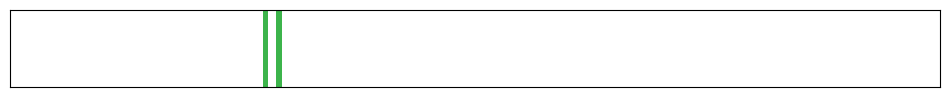

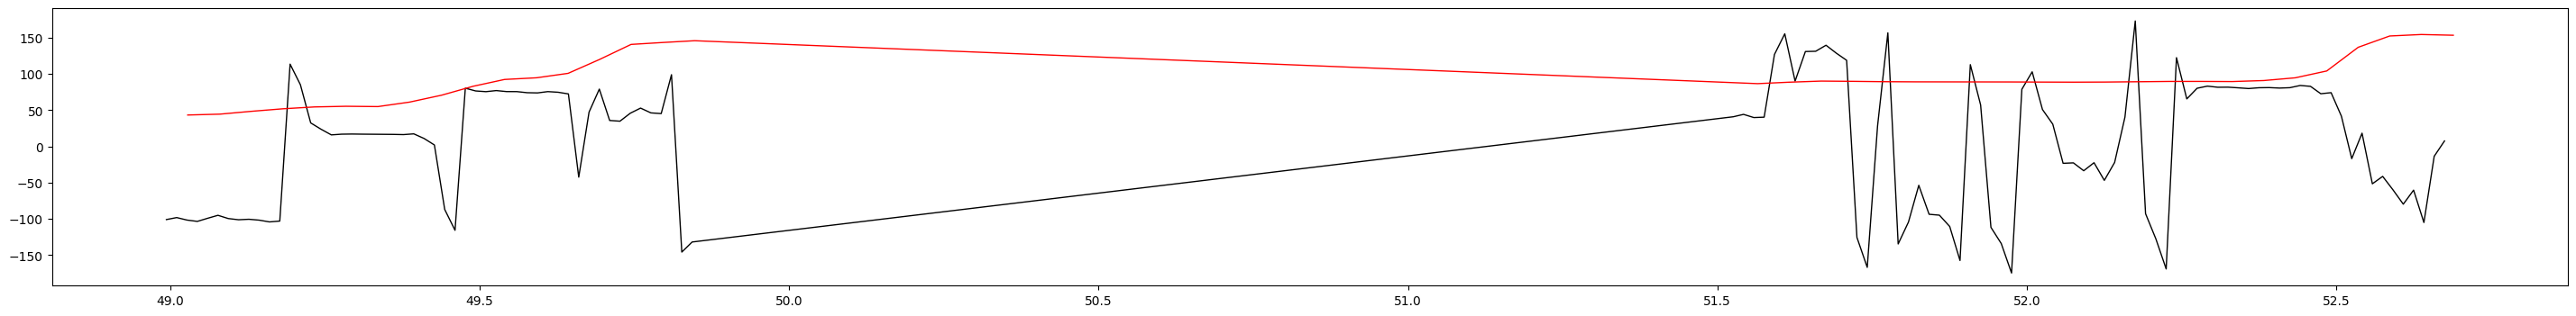

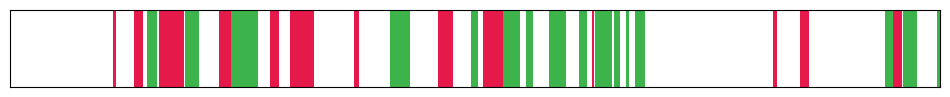

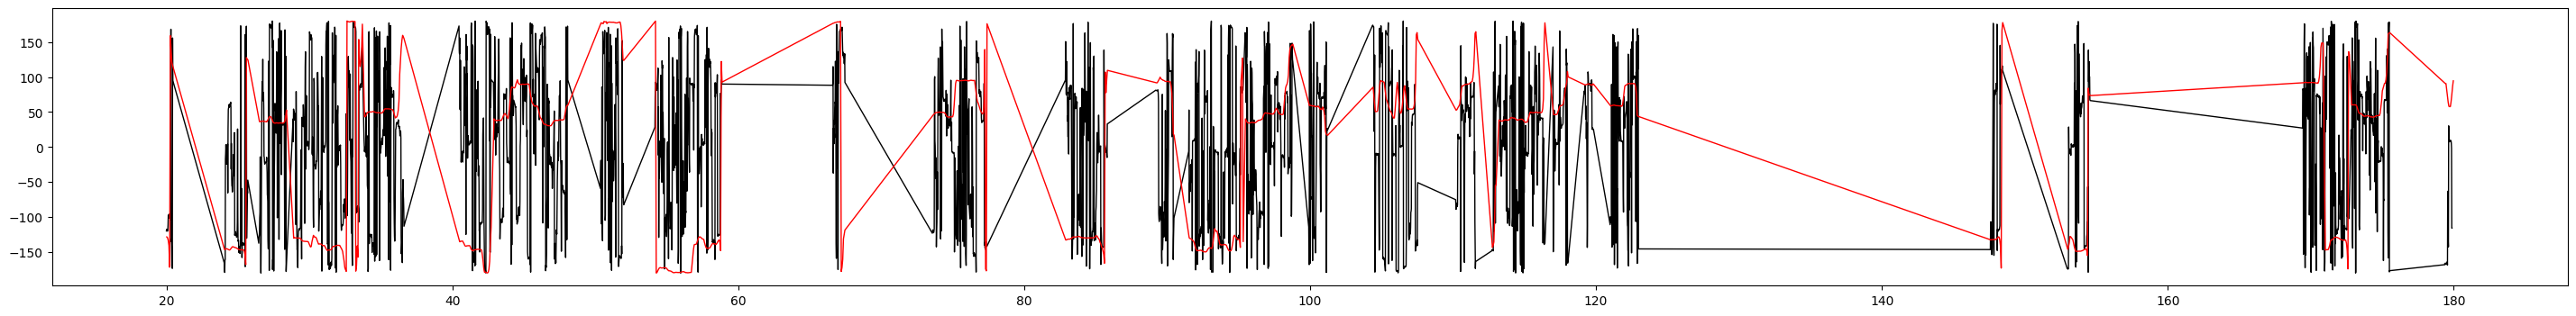

In [7]:
# ANALYSIS OF ARROW AND EYE DIRECTION
data = load_nested_dict('data/Processed') 
def get_index_in_intervals(intervals, x):
    within_intervals = np.logical_and(x[:, np.newaxis] >= intervals[:, 0], x[:, np.newaxis] <= intervals[:, 1])
    return np.where(within_intervals)[0]

def compute_eye_directions(df_eye):
    z = df_eye[['x','y']].to_numpy()
    z1, z2 = z[:-1], z[1:]
    d = z2 - z1
    a = np.arctan2(d[:,1], d[:,0]) * (180/np.pi) # degrees
    a = np.pad(a, (0,1))
    a[-1] = a[-2]
    df_eye['angle'] = a
    return df_eye

for participant, _data1 in data.items():
    for experiment, _data2 in _data1.items():
        if 'icua' in experiment:
            warning_data = _data2['warnings']
            warning_intervals = []
            start_time, finish_time = _data2['start_time'], _data2['finish_time']
            fig = plt.figure(figsize=(12,1))
            init_axis(plt.gca(), start_time, finish_time)
            for task, task_data in warning_data.items():
                intervals = compute_time_intervals(task_data['value'].astype(int), task_data['timestamp'], start_time, finish_time)
                warning_intervals.append(intervals.intervals)
                plot_intervals(intervals.intervals, plt.gca(), color=ALL_WINDOW_PROPERTIES[task]['color'], alpha=1)
                
            # plot arrow data...
            #for t in _data2['arrow']['timestamp']:
            #     plt.gca().axvline(t, color="black", linewidth=1, alpha=0.1)
            eye_data = compute_eye_directions(_data2['eye_tracking'])
            arrow_data = _data2['arrow']
            
            # the warning intervals are when the arrow is shown... get the eye tracking data for these intervals only
            warning_intervals = merge_intervals(warning_intervals)
            indx = get_index_in_intervals(warning_intervals, _data2['eye_tracking']['timestamp'].to_numpy())
            eye_in_warning = eye_data.loc[indx]
            
            plt.figure(figsize=(36,4))
            plt.plot(eye_in_warning['timestamp'] - start_time, eye_in_warning['angle'], color="black", linewidth=1)
            #init_axis(plt.gca(), eye_in_warning['timestamp'].min(), eye_in_warning['timestamp'].max())
            
            plt.plot(arrow_data['timestamp'] - start_time, arrow_data['angle'], color="red", linewidth=1)
            #plt.gca().set_xlim(start_time, finish_time)
            
            #for t in eye_in_warning['timestamp']:
            #     plt.gca().axvline(t, color="black", linewidth=1, alpha=0.01)
        
            
                
    
    
    break
    